In [5]:
print('ok')

ok


In [6]:
import sys
print(sys.executable)


c:\Users\Madhu Kumar\Desktop\My Learnings\LLMops\Multi Agent System\automated-research-report-generation\.venv\Scripts\python.exe


In [7]:
from research_and_analyst.utils.model_loader import ModelLoader


In [8]:
model_loader = ModelLoader()

{"timestamp": "2026-02-15T08:27:10.630442Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2026-02-15T08:27:10.631442Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2026-02-15T08:27:10.632440Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2026-02-15T08:27:10.633440Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2026-02-15T08:27:10.645437Z", "level": "info", "event": "YAML config loaded"}


In [9]:
llm = model_loader.load_llm()

{"provider": "groq", "model": "llama-3.1-8b-instant", "timestamp": "2026-02-15T08:27:11.085445Z", "level": "info", "event": "Loading LLM"}


In [10]:
llm.invoke('What is the capital of France?').content

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


'The capital of France is Paris.'

In [11]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel,Field

In [12]:
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import AIMessage, HumanMessage,SystemMessage
from langgraph.checkpoint.memory import MemorySaver
 

In [137]:
class Analyst(BaseModel):
    name : str = Field(description="Name of the analyst")
    role : str = Field(description="Role of the analyst in the context of topic assigned")
    affiliation : str = Field(description="Affiliation of the analyst to any organization or institution")
    description : str = Field(description="Brief description about the analyst, their expertise and background")

    @property
    def persona(self) -> str:
        return f""" You are {self.name}, a {self.role} from {self.affiliation}. {self.description}"""
        


In [138]:
analyst = Analyst(name = "Madhu Kumar",
 role = "Data Scientist",
  affiliation = "Tech Company",
   description = "Madhu has 5 years of experience in data science and specializes in machine learning and AI.")

In [139]:
print(analyst.persona)

 You are Madhu Kumar, a Data Scientist from Tech Company. Madhu has 5 years of experience in data science and specializes in machine learning and AI.


In [140]:
class Perspective(BaseModel):
    analysts : List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations who will be providing their perspectives on the research topic.")

In [141]:
class GenerateAnalystState(TypedDict):
    topic : str # research topic for which analyst needs to be created
    max_analysts : int  # maximum number of analysts that can be created for the research topic
    human_analyst_feedback : str   # feedback provided by human analyst after reviewing the work of AI analyst
    analysts :List[str]   #Analyst asking questions

In [142]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [145]:
def create_analyst(state: GenerateAnalystState):
    """
    Creates analysts based on topic and max_analysts
    """
    topic = state['topic']
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback")

    structured_llm = llm.with_structured_output(Perspective)

    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )

    analysts = structured_llm.invoke([
        SystemMessage(content=system_messages)
    ] + [
        HumanMessage(content=f"Generate EXACTLY {max_analysts} analysts.")
    ])

    # Validate and truncate if needed
    analyst_list = analysts.analysts[:max_analysts]  # Take only first max_analysts
    
    print(f"Created {len(analyst_list)} analysts (requested: {max_analysts})")

    return {"analysts": analyst_list}




In [147]:
create_analyst(
    {'topic':'finance',
    'max_analysts': 3,
    'human_analyst_feedback':'give the real info'}
)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Created 3 analysts (requested: 3)


{'analysts': [Analyst(name='Emily Chen', role='Financial Analyst', affiliation='Goldman Sachs', description='Emily is a seasoned financial analyst with over 10 years of experience in investment banking and equity research. She has a strong background in financial modeling and has worked with numerous clients across various industries.'),
  Analyst(name='David Lee', role='Economist', affiliation='Federal Reserve', description='David is a renowned economist with expertise in monetary policy and macroeconomic analysis. He has published numerous papers on the topic of economic growth and has worked closely with policymakers to inform their decisions.'),
  Analyst(name='Sarah Taylor', role='Investment Strategist', affiliation='BlackRock', description='Sarah is a highly respected investment strategist with a focus on asset allocation and portfolio management. She has worked with institutional clients to develop customized investment solutions and has a deep understanding of the global financ

In [148]:
def human_feedback(state):
    """
    No-op node that should be interrupted on
    """
    pass

In [149]:
def should_continue(state):
    """ Return the next node to execute"""

    human_analyst_feedback = state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analyst"


In [150]:
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from langgraph.checkpoint.memory import MemorySaver


In [151]:
builder = StateGraph(GenerateAnalystState)

In [152]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback",human_feedback)

In [153]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst","human_feedback")
builder.add_conditional_edges("human_feedback",
should_continue,
["create_analyst",
END])

In [154]:
memory = MemorySaver()

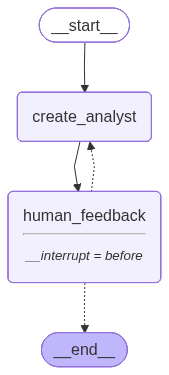

In [155]:
graph = builder.compile(interrupt_before = ["human_feedback"],checkpointer = memory)
graph

In [156]:
topic = "the benefits of adopting Langraph as an agent framework"


In [157]:
max_analysts = 4

In [158]:
thread = {"configurable":{"thread_id":1}}

In [159]:
for event in graph.stream({"topic":topic,
    "max_analysts":max_analysts},
    thread,
    stream_mode = "values"):
    analysts = event.get('analysts','')

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Created 4 analysts (requested: 4)
Name: Emily Chen
Affiliation: Stanford University
Role: AI Researcher
Description: Expertise in multi-agent systems and reinforcement learning
--------------------------------------------------
Name: David Lee
Affiliation: Microsoft
Role: Software Engineer
Description: Experience in developing scalable and efficient AI frameworks
--------------------------------------------------
Name: Sophia Patel
Affiliation: Google
Role: Data Scientist
Description: Knowledge in natural language processing and machine learning
--------------------------------------------------
Name: Kevin White
Affiliation: MIT
Role: Computer Vision Specialist
Description: Expertise in computer vision and robotics
--------------------------------------------------


In [33]:
state = graph.get_state(thread)
state

StateSnapshot(values={'topic': 'the benefits of adopting Langraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Emily Chen', role='AI Researcher', affiliation='Stanford University', description='Expert in agent frameworks and their applications in AI research'), Analyst(name='David Lee', role='Software Engineer', affiliation='Microsoft', description='Skilled in developing and implementing agent frameworks for large-scale systems'), Analyst(name='Sophia Patel', role='Data Scientist', affiliation='Google', description='Specialized in data analysis and visualization for AI applications'), Analyst(name='Kevin White', role='AI Ethics Specialist', affiliation='MIT', description='Expert in AI ethics and responsible AI development'), Analyst(name='Rachel Kim', role='Computer Vision Engineer', affiliation='Facebook', description='Skilled in developing computer vision systems and their applications in AI'), Analyst(name='Oliver Brown', role='Machine Learning Engineer', af

In [160]:
state.next

AttributeError: 'dict' object has no attribute 'next'

In [31]:
graph.update_state(thread,
{"human_analyst_feedback":"The analysts are good but can you make them more focused on the ethical implications of adopting Langraph?"},
as_node = "human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10968b-a92b-6037-8002-04fbf26b901b'}}

In [55]:
# further_feedack = None
# graph.update_state(thread, {"human_analyst_feedback":None}, as_node="human_feedback")

In [ ]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

# Second Workflow

In [161]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_api_key = os.getenv("TAVILY_API_KEY")

taviy_search = TavilySearchResults(tavily_api_key = tavily_api_key)

web_search_results = taviy_search.invoke({"query":"What is Langgraph?"})

print(web_search_results)


docs = WikipediaLoader(query="Langgraph").load()

print(docs[0].page_content[:500])


[{'title': 'What is LangGraph? - IBM', 'url': 'https://www.ibm.com/think/topics/langgraph', 'content': '# What is LangGraph?\n\n## Authors\n\nBryan Clark \n\nSenior Technology Advocate\n\n## LangGraph overview\n\nLangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video games.\n\nLLM applications: By using LangGraph’s capabilities, developers can build more sophisticated AI models that learn and improve over time. Norwegia

In [162]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_api_key = os.getenv("TAVILY_API_KEY")

tavily_search = TavilySearchResults(tavily_api_key = tavily_api_key)

web_search_results = tavily_search.invoke({"query":"What is Langgraph?"})

print(web_search_results)


docs = WikipediaLoader(query="Langgraph").load()

print(docs[0].page_content[:500])


[{'title': 'What is LangGraph? - IBM', 'url': 'https://www.ibm.com/think/topics/langgraph', 'content': '# What is LangGraph?\n\n## Authors\n\nBryan Clark \n\nSenior Technology Advocate\n\n## LangGraph overview\n\nLangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video games.\n\nLLM applications: By using LangGraph’s capabilities, developers can build more sophisticated AI models that learn and improve over time. Norwegia

In [163]:
from typing import Annotated
import operator 
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int  # number of turns in conversation
    context: Annotated[list,operator.add]  # source docs
    analyst : Analyst   # Analyst asking questions
    interview : str     # Interview Transcript
    sections : list    # Final key we duplicate in outer state for send APIs

class Searchquery(BaseModel):
        query: str = Field(None, description = "search query for retrieval")

In [164]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


In [165]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic.\n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals:  You are Kevin White, a Computer Vision Specialist from MIT. Expertise in computer vision and robotics\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.'

In [166]:
def generation_question(state:InterviewState):
    """Node to generate questions"""

    # get state
    analyst = state["analyst"]
    messages = state["messages"]

    # generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

# return the question through state
    return {"messages":[question]}



In [41]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="Hi do proper research")]}

In [42]:
result = generation_question(state)


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [78]:
print(result["messages"][0].content)

Nice to meet you, I'm Dr. Michael Brown, a Research Scientist at the University of California, Berkeley, specializing in Artificial Intelligence and Robotics. I'm excited to share my expertise with you today.

To get started, I'd love to dive into the world of AI and robotics. Can you tell me, what's the most significant misconception people have about AI and robotics, and how do you think it affects the field's development and public perception?


In [167]:
from langchain_core.messages import get_buffer_string


In [168]:
search_instructions = SystemMessage(content=f"""you will be given a conversation between an analyst and an expert.
your goal is to generate a well-structured query for use i retrieval and /or web-search related to the conversation.
First,analyze the full conversation.
Pay Particular attention to the final_question posted by the analyst
Convert this final question into a well-structured web search query""")

In [169]:
def search_web(state:InterviewState):
    """
    Retrieve relevant information from the web

    """
    structure_llm = llm.with_structured_output(Searchquery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])

    # search
    search_docs = tavily_search.invoke(search_query.query)

    # Format
    formatted_search_docs = "\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs


        ]
    )

    return {"context": [formatted_search_docs]}

In [46]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[AIMessage(content="Hello my name is I'm Dr. Michael Brown, a Research Scientist at the University of California, Berkeley, specializing in Artificial Intelligence and Robotics. I'm excited to share my expertise with you today.To get started, I'd love to dive into the world of AI and robotics. Can you tell me, what's the most significant misconception people have about AI and robotics, and how do you think it affects the field's development and public perception?")]}

In [ ]:
result = search_web(state)


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [103]:
print(result["context"][0])

<Document href="https://harimus.github.io/2024/05/31/motortask.html"/>
the doorknob and applying the required force to turn it, expecting resistance. [...] ## Background

As I work in robotics research, I’ve often had to explain the difference between Robotics and Artificial Intelligence (AI). The two fields have obvious overlaps, but as things have developed, especially recently, there’s more difference even in the methods of automation. In the public perception, those two fields are often seen as equivalent.

When people talk about AI threats, this is the face they often imagine. [...] is worth a mention, along with Google (previously Everyday Robots). The academic effort to create a dataset to train these models (RT-X) should probably also be mentioned.
</Document>

<Document href="https://charitydigital.org.uk/topics/4-common-charity-misconceptions-about-artificial-intelligence1-6149"/>
It’s easy to believe that AI – probably the most hyped technology of all – is just another one o

In [170]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki

    """
    # search query

    structured_llm = llm.with_structured_output(Searchquery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # search

    search_docs = WikipediaLoader(query=search_query.query,load_max_docs=2).load()

    # format

    formatted_search_docs = "\n\n--\n\n".join(
        [
            f'<Document source = "{doc.metadata["source"]}" page = "{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [171]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[AIMessage(content="Hello my name is I'm Dr. Michael Brown, a Research Scientist at the University of California, Berkeley, specializing in Artificial Intelligence and Robotics. I'm excited to share my expertise with you today.To get started, I'd love to dive into the world of AI and robotics. Can you tell me, what's the most significant misconception people have about AI and robotics, and how do you think it affects the field's development and public perception?")]}

In [172]:
result = search_wikipedia(state)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [173]:
print(result["context"][0])

<Document source = "https://en.wikipedia.org/wiki/Social_credit_system" page = ""/>
The social credit system (Chinese: 社会信用体系; pinyin: shèhuì xìnyòng tǐxì) is a national credit rating and blacklist implemented by the government of the People's Republic of China. The social credit system is a record system so that businesses, individuals, and government institutions can be tracked and evaluated for trustworthiness. It is based on varying degrees of whitelisting (termed "redlisting" in China) and blacklisting. There have been widespread misconceptions in media reports that China operates a unitary social credit "score" based on individuals' behavior, leading to punishments if the score is too low or rewards if the score is high.
The origin of the concept can be traced back to the 1980s when the Chinese government attempted to develop a personal banking and financial credit rating system, especially for rural individuals and small businesses who lacked documented records. The program firs

In [174]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/> then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation.
"""


In [175]:
def generate_answer(state: InterviewState):
    """Node to answer a question"""

    # Get state

    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # answer question
    system_message = answer_instructions.format(goals = analyst.persona, context = context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from expert

    answer.name = "expert"

    # Append it to state

    return{"messages":[answer]}

In [176]:
section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum

6. In the Sources section:
- Include all sources used in the report, as referenced in the report [1], [2], etc
- provide full links to relevant website or specific document paths
- seperate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown
- It will look like:

### Sources
[1] Source 1 Link or Document name
[2] Source 2 Link or Document name

7. Be sure to combine sources. For Example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be not redundant sources. It should simply be:

8. Final review
-  Ensure the report follows the required structure
- Include no preamble before the title of the report
- check that all sources cited in the report are included in the sources list at the bottom
"""


In [177]:
def route_messages(state: InterviewState,
                    name: str = "expert"):

    """Route between question and answer"""

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns",2)

    # check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"

    # this router is run after each question -answer pair
    # Get the last question asked to check if it signals at the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help!" in last_question.content:
        return "save_interview"
    return "ask_question"

    

In [178]:
def save_interview(state: InterviewState):
    """ Save Interview """

    # Get Messages

    messages = state["messages"]

    # Convert interview to a string

    interview = get_buffer_string(messages)

    # save to interviews key

    return {"interview": interview}

In [179]:
section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum

6. In the Sources section:
- Include all sources used in the report, as referenced in the report [1], [2], etc
- provide full links to relevant website or specific document paths
- seperate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown
- It will look like:

### Sources
[1] Source 1 Link or Document name
[2] Source 2 Link or Document name

7. Be sure to combine sources. For Example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be not redundant sources. It should simply be:

8. Final review
-  Ensure the report follows the required structure
- Include no preamble before the title of the report
- check that all sources cited in the report are included in the sources list at the bottom
"""

In [180]:
def write_section(state: InterviewState):
    """Node to answer a question"""

    # Get state
    analyst = state["analyst"]
    interview = state["interview"]
    context = state["context"]

    # write section using either the gathered source docs from interview (context) or the interview itself (interview)

    system_message = section_writer_instructions.format(focus = analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content = f"use this source to write your section:{context}")])

    # Append it to state
    return {"sections":[section.content]}

In [181]:
interview_builder = StateGraph(InterviewState)

In [182]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [183]:
from langgraph.graph import START, END

In [184]:
interview_builder.add_edge(START,"ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                        route_messages,
                        ["ask_question",
                        "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section", END)





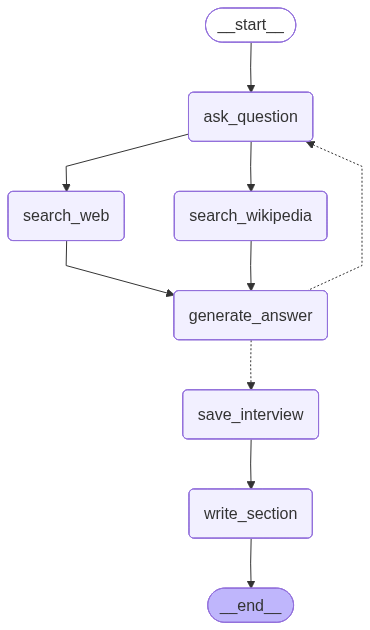

In [185]:
interview_graph = interview_builder.compile(checkpointer = memory).with_config(run_name = "Conduct Interview")
interview_graph


In [186]:
analyst

Analyst(name='Kevin White', role='Computer Vision Specialist', affiliation='MIT', description='Expertise in computer vision and robotics')

In [187]:
from IPython.display import display, Markdown

In [188]:
messages = [HumanMessage(f"So you said you were writing an article on langgraph")]

In [189]:
thread = {"configurable":{"thread_id":1}}

In [ ]:
interview = interview_graph.invoke({"messages":messages,"analyst":analyst,"max_num_turns":2}, thread)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 32.000000 seconds
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /openai/v1/chat/completions in 

In [68]:
Markdown(interview['sections'][0])

## Robotics and Large Language Models: A Promising Future

### Summary

The integration of Large Language Models (LLMs) in robotics has shown significant advancements in recent years. This report highlights the current state of LLMs in robotics, their applications, and the potential benefits they bring to the field. The integration of LLMs in robotics can improve aspects such as human-robot interaction, navigation, planning, and decision-making. This report also explores the use of LangGraph, a framework for building stateful, multi-agent applications powered by LLMs.

### Sources

[1] https://arxiv.org/html/2311.07226v2
[2] https://www.blog.langchain.com/top-5-langgraph-agents-in-production-2024/
[3] https://www.nature.com/articles/s42256-025-01005-x
[4] https://arxiv.org/html/2506.09581v1
[5] https://towardsai.net/p/l/langgraph-chat-models-tools-dynamic-execution
[6] https://www.ibm.com/think/topics/langgraph
[7] https://www.rapidinnovation.io/post/ai-agents-in-langgraph
[8] https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications
[9] https://www.scalablepath.com/machine-learning/langgraph
[10] https://www.digitalocean.com/community/tutorials/local-ai-agents-with-langgraph-and-ollama

# Third work flow

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated,List
import operator

class ResearchGraphState(TypedDict):
    """State for the research graph"""

    topic : str # Research topic
    max_analysts : int   # Number of analyst
    human_analyst_feedback : str  
    analyst : list[Analyst]
    sections: Annotated[list,operator.add]
    introductio : str
    content : str
    conclusion : str
    final_report : str

   

In [ ]:
from langgraph.types import Send

In [ ]:
def initiate_all_interviews(state: ResearchGraphState):
    """
    Conditional edge to fan out interviews to all analysts
    """
    # Check if analysts exist
    if "analysts" not in state or not state.get("analysts"):
        # No analysts yet, loop back to create them
        return "create_analysts"
    
    # Get the topic from state
    topic = state.get("topic", "")
    
    # Fan out to conduct interviews for each analyst using Send
    return [
        Send(
            "conduct_interview",
            {
                "analyst": analyst,
                "messages": [
                    HumanMessage(
                        content=f"Please help me write an article on {topic}"
                    )
                ],
            }
        ) for analyst in state["analysts"]
    ]

In [1]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]
    
    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+(HumanMessage(content="...")))
    return {"content": report.content}

NameError: name 'ResearchGraphState' is not defined

In [ ]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the '## Sources' header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

In [104]:
intro_conclusion_instructions = """You are a technical writer creating a conclusion for a research report on this overall topic:

{topic}

You have been provided with the full report sections that synthesize findings from multiple analyst memos.

Your task:

1. Review all the sections provided to understand the key findings and insights.
2. Synthesize the main takeaways into a compelling conclusion.
3. Highlight the most significant findings and their implications.
4. Identify any patterns, trends, or connections across the different sections.
5. Provide a forward-looking perspective on the topic if appropriate.
6. Keep the conclusion concise and impactful - aim for 2-4 paragraphs.

Important formatting guidelines:

- Do not introduce new information or citations not present in the sections.
- Do not repeat the introduction or simply restate the sections.
- Maintain the same tone and technical depth as the rest of the report.
- End with a strong closing statement that reinforces the report's key message.

Here are the report sections to base your conclusion on:

{formatted_str_sections}"""

In [105]:
def write_introduction(state:ResearchGraphState):
    # full set of sections
    sections = state["sections"]
    topic = state["topic"]

    #concat all sections together

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # summarizee the sections into a final report
    instructions = intro_conclusion_instructions.format(topic=topic,formatted_str_sections = formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"write the report introduction")])
    return {"introduction": intro.content}

In [106]:
def write_conclusion(state:ResearchGraphState):

    # full set of sections
    sections = state["sections"]
    topic = state["topic"]

    #concat all sections together

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # summarizee the sections into a final report
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections = formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"write the report conclusion")])
    return {"conclusion": conclusion.content}

In [107]:
def finalize_report(state:ResearchGraphState):
    """This is the "reduce" step where we gather all the sections,combine them,and reflect on them to write the intro/conclusion"""
    # save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip('## Insights')
    if '## Sources in content':
        try:
            content,sources = content.split("\n## Sources\n")
        except:
                sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n--\n\n" + content + "\n\n--\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


    

In [108]:
# Add nodes and edges

builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)  # Fixed: removed quotes
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# Logic

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")  # Fixed: typo "write_introdcution"
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

In [109]:
memory = MemorySaver()

In [117]:
# Compile with interrupt
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=["human_feedback"]
)

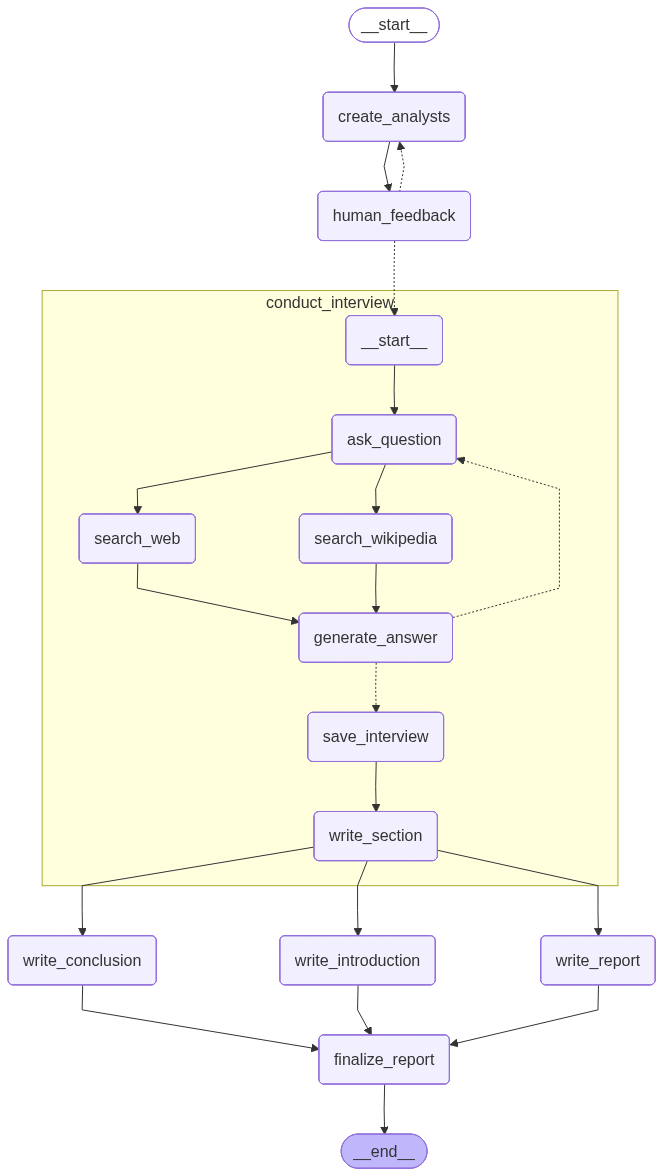

In [110]:
# If you want to see everything in one view, use xray parameter
from IPython.display import Image, display
graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [130]:
max_analysts = 2

In [131]:
topic = "How can generative AI accelerate drug discovery"

In [132]:
thread = {"configurable":{"thread_id":"1"}}

In [127]:
# run the graph until the first interruption

In [133]:
graph.update_state(thread,{"human_analyst_feedback":"add the future uses of genai in the clinical trials also along with drug discovery"},as_node = "human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10a609-6619-6375-8006-6cd33472f606'}}

In [134]:
for event in graph.stream(
    {
        "topic":topic,
        "max_analysts":max_analysts
    },
    thread,
    stream_mode="values"
):
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name:{analyst.name}")
            print(f"Affiliation:{analyst.affiliation}")
            print(f"Role:{analyst.role}")
            print(f"Description:{analyst.description}")
            print("-"*50)
        



Name:Dr. Rachel Kim
Affiliation:Stanford University
Role:AI Researcher
Description:Dr. Kim is a leading expert in AI and machine learning, with a focus on natural language processing and computer vision. She has published numerous papers on the application of AI in healthcare and has a strong background in drug discovery.
--------------------------------------------------
Name:Dr. Liam Chen
Affiliation:Google Health
Role:Data Scientist
Description:Dr. Chen is a seasoned data scientist with expertise in genomics and precision medicine. He has worked on several high-profile projects, including the development of AI-powered clinical decision support systems.
--------------------------------------------------
Name:Dr. Sofia Patel
Affiliation:University of California, San Francisco
Role:Clinical Trials Expert
Description:Dr. Patel is a renowned expert in clinical trials and regulatory affairs. She has extensive experience in the design and execution of clinical trials, including those invol

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name:Dr. Rachel Kim
Affiliation:Stanford University
Role:AI Researcher
Description:Dr. Kim is a leading expert in AI and machine learning, with a focus on natural language processing and computer vision. She has published numerous papers on the application of AI in healthcare and has a strong background in drug discovery.
--------------------------------------------------
Name:Dr. Liam Chen
Affiliation:Google Health
Role:Data Scientist
Description:Dr. Chen is a seasoned data scientist with expertise in genomics and precision medicine. He has worked on several high-profile projects, including the development of AI-powered clinical decision support systems.
--------------------------------------------------
Name:Dr. Sophia Patel
Affiliation:University of California, San Francisco
Role:Clinical Researcher
Description:Dr. Patel is a clinical researcher with a focus on oncology and immunology. She has experience in designing and conducting clinical trials and has a strong understanding of t

In [123]:
graph.update_state(thread,{"human_analyst_feedback":"add the future uses of genai in the clinical trials also along with drug discovery"},as_node = "human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10a5f9-907e-6a90-8002-05ed1bbf6c9a'}}

In [129]:
graph.get_state(thread).next

('human_feedback',)